In [ ]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.font_manager as fm
import warnings
import sqlite3
from datetime import datetime, timedelta
import seaborn as sns
warnings.filterwarnings('ignore')

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

# 1) 확장 기상 데이터 생성

In [ ]:
# ============================================================================
# 1단계: 확장된 기상 데이터 생성 (온도, 습도, 강수량, 풍속, 기압)
# ============================================================================

def create_extended_weather_data():
    """2개월치 종합 기상 데이터 생성"""
    print("\n1  확장된 기상 데이터 생성 중...")

    # 2024년 11월 1일부터 12월 31일까지
    start_date = datetime(2024, 11, 1)
    end_date = datetime(2024, 12, 31)

    # 날짜 리스트 생성
    dates = []
    current_date = start_date
    while current_date <= end_date:
        dates.append(current_date)
        current_date += timedelta(days=1)

    weather_data = []

    for i, date in enumerate(dates):
        # 계절 진행도 (0~1, 11월 초에서 12월 말까지)
        season_progress = i / (len(dates) - 1)

        # 1. 온도 데이터 (기존과 동일)
        base_temp = 15 - season_progress * 10  # 15도에서 5도로 감소
        temperature = round(base_temp + np.random.normal(0, 3), 1)

        # 2. 습도 데이터 (30-90%, 겨울로 갈수록 약간 감소)
        base_humidity = 70 - season_progress * 10  # 70%에서 60%로 감소
        humidity = round(max(30, min(90, base_humidity + np.random.normal(0, 10))), 1)

        # 3. 강수량 데이터 (0-50mm, 가끔 비 오는 날)
        # 20% 확률로 비가 옴
        if np.random.random() < 0.2:
            rainfall = round(np.random.exponential(5), 1)  # 지수분포로 현실적인 강수량
            rainfall = min(rainfall, 50)  # 최대 50mm
        else:
            rainfall = 0.0

        # 4. 풍속 데이터 (0-20 m/s, 겨울로 갈수록 증가)
        base_wind = 3 + season_progress * 5  # 3m/s에서 8m/s로 증가
        wind_speed = round(max(0, base_wind + np.random.normal(0, 2)), 1)
        wind_speed = min(wind_speed, 20)  # 최대 20m/s

        # 5. 기압 데이터 (980-1030 hPa)
        base_pressure = 1013 + np.random.normal(0, 10)
        pressure = round(max(980, min(1030, base_pressure)), 1)

        # 6. 날씨 상태 결정 (강수량과 온도 기반)
        if rainfall > 0:
            if temperature < 0:
                weather_condition = "눈"
            else:
                weather_condition = "비"
        elif humidity > 80:
            weather_condition = "흐림"
        elif humidity < 40:
            weather_condition = "맑음"
        else:
            weather_condition = "구름조금"

        # 데이터 수집
        weather_data.append({
            'date': date.strftime('%Y-%m-%d'),
            'temperature': temperature,
            'humidity': humidity,
            'rainfall': rainfall,
            'wind_speed': wind_speed,
            'pressure': pressure,
            'weather_condition': weather_condition,
            'month': date.month,
            'day': date.day,
            'weekday': date.weekday(),  # 0=월요일, 6=일요일
            'is_weekend': 1 if date.weekday() >= 5 else 0
        })

    # DataFrame 생성
    df = pd.DataFrame(weather_data)

    # CSV 파일로 저장
    df.to_csv('extended_weather_data.csv', index=False, encoding='utf-8')
    print(f" 확장 기상 데이터 생성 완료! 총 {len(df)}일치 데이터")
    print(f" 포함된 데이터: 온도, 습도, 강수량, 풍속, 기압, 날씨상태")

    return df

# 확장된 기상 데이터 생성
weather_df = create_extended_weather_data()


1  확장된 기상 데이터 생성 중...
 확장 기상 데이터 생성 완료! 총 61일치 데이터
 포함된 데이터: 온도, 습도, 강수량, 풍속, 기압, 날씨상태


# 2)  CSV 파일 읽기 및 탐색

In [ ]:
# ============================================================================
# 2단계: 확장된 CSV 파일 읽기 및 탐색
# ============================================================================

def explore_extended_weather_data(filename='extended_weather_data.csv'):
    """확장된 기상 데이터 탐색"""
    print(f"\n2  확장된 기상 데이터 탐색: {filename}")

    # CSV 파일 읽기
    df = pd.read_csv(filename)

    print(f" 파일 읽기 성공!")
    print(f" 데이터 형태: {df.shape}")
    print(f" 컬럼: {list(df.columns)}")

    # 처음 10행 출력
    print("\n 데이터 미리보기:")
    print(df.head(10))

    # 각 기상 요소별 기본 통계
    print("\n 기상 요소별 기본 통계:")
    numeric_columns = ['temperature', 'humidity', 'rainfall', 'wind_speed', 'pressure']
    print(df[numeric_columns].describe().round(2))

    # 날씨 상태별 빈도
    print("\n  날씨 상태별 일수:")
    weather_counts = df['weather_condition'].value_counts()
    for condition, count in weather_counts.items():
        print(f"   {condition}: {count}일")

    # 강수 일수
    rainy_days = len(df[df['rainfall'] > 0])
    print(f"\n  강수 일수: {rainy_days}일 ({rainy_days/len(df)*100:.1f}%)")

    return df

# 데이터 탐색
weather_df = explore_extended_weather_data()



2  확장된 기상 데이터 탐색: extended_weather_data.csv
 파일 읽기 성공!
 데이터 형태: (61, 11)
 컬럼: ['date', 'temperature', 'humidity', 'rainfall', 'wind_speed', 'pressure', 'weather_condition', 'month', 'day', 'weekday', 'is_weekend']

 데이터 미리보기:
         date  temperature  humidity  rainfall  wind_speed  pressure  \
0  2024-11-01         10.1      61.5       1.2         3.8    1013.7   
1  2024-11-02         18.6      82.8       0.0         5.2    1009.3   
2  2024-11-03         14.3      70.7       0.0         4.7    1012.9   
3  2024-11-04          9.8      72.1       0.0         3.9    1022.3   
4  2024-11-05         13.0      70.8       0.0         4.8    1004.1   
5  2024-11-06         12.7      73.5       0.0         1.0    1026.1   
6  2024-11-07         13.0      75.6       0.0         4.9    1009.4   
7  2024-11-08         12.4      70.7       0.0         7.0    1003.0   
8  2024-11-09         18.4      59.9       0.0         4.1    1018.3   
9  2024-11-10         15.7      76.9       1.9       

# 3) SQLite 데이터베이스 생성

In [ ]:
# ============================================================================
# 3단계: 확장된 SQLite 데이터베이스 생성
# ============================================================================

def create_extended_weather_database(df, db_name='extended_weather.db'):
    """확장된 기상 데이터베이스 생성"""
    print(f"\n3  확장된 기상 데이터베이스 생성: {db_name}")

    conn = sqlite3.connect(db_name)
    cur = conn.cursor()

    # 기존 테이블 삭제
    cur.execute("DROP TABLE IF EXISTS weather_data")

    # 확장된 테이블 생성
    cur.execute('''
        CREATE TABLE weather_data (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            date TEXT NOT NULL,
            temperature REAL NOT NULL,
            humidity REAL NOT NULL,
            rainfall REAL NOT NULL,
            wind_speed REAL NOT NULL,
            pressure REAL NOT NULL,
            weather_condition TEXT NOT NULL,
            month INTEGER NOT NULL,
            day INTEGER NOT NULL,
            weekday INTEGER NOT NULL,
            is_weekend INTEGER NOT NULL,
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
    ''')

    print(" 확장된 테이블 생성 완료!")
    print(" 테이블 구조:")
    print("   - 기본: ID, 날짜, 생성시간")
    print("   - 기상: 온도, 습도, 강수량, 풍속, 기압")
    print("   - 분류: 날씨상태, 월, 일, 요일, 주말여부")

    # 데이터 삽입
    print("\n 데이터 삽입 중...")
    for _, row in df.iterrows():
        cur.execute('''
            INSERT INTO weather_data
            (date, temperature, humidity, rainfall, wind_speed, pressure,
             weather_condition, month, day, weekday, is_weekend)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (row['date'], row['temperature'], row['humidity'], row['rainfall'],
              row['wind_speed'], row['pressure'], row['weather_condition'],
              row['month'], row['day'], row['weekday'], row['is_weekend']))

    conn.commit()

    # 데이터 확인
    cur.execute("SELECT COUNT(*) FROM weather_data")
    count = cur.fetchone()[0]
    print(f" 데이터 삽입 완료! 총 {count}개 레코드")

    conn.close()
    return True

# 확장된 데이터베이스 생성
create_extended_weather_database(weather_df)


3  확장된 기상 데이터베이스 생성: extended_weather.db
 확장된 테이블 생성 완료!
 테이블 구조:
   - 기본: ID, 날짜, 생성시간
   - 기상: 온도, 습도, 강수량, 풍속, 기압
   - 분류: 날씨상태, 월, 일, 요일, 주말여부

 데이터 삽입 중...
 데이터 삽입 완료! 총 61개 레코드


True

# 4) 분석

In [ ]:
def advanced_weather_analysis(db_name='extended_weather.db'):
    """고급 기상 데이터 분석"""
    print(f"\n4  고급 기상 데이터 분석")

    conn = sqlite3.connect(db_name)

    # 1. 월별 종합 통계
    monthly_stats = pd.read_sql_query("""
        SELECT
            month,
            COUNT(*) as total_days,
            ROUND(AVG(temperature), 1) as avg_temp,
            ROUND(AVG(humidity), 1) as avg_humidity,
            ROUND(SUM(rainfall), 1) as total_rainfall,
            ROUND(AVG(wind_speed), 1) as avg_wind,
            ROUND(AVG(pressure), 1) as avg_pressure,
            COUNT(CASE WHEN rainfall > 0 THEN 1 END) as rainy_days
        FROM weather_data
        GROUP BY month
        ORDER BY month
    """, conn)

    print(" 월별 종합 통계:")
    for _, row in monthly_stats.iterrows():
        month_name = "11월" if row['month'] == 11 else "12월"
        print(f"\n   {month_name}:")
        print(f"     평균 온도: {row['avg_temp']}°C")
        print(f"     평균 습도: {row['avg_humidity']}%")
        print(f"     총 강수량: {row['total_rainfall']}mm")
        print(f"     평균 풍속: {row['avg_wind']}m/s")
        print(f"     평균 기압: {row['avg_pressure']}hPa")
        print(f"     강수 일수: {row['rainy_days']}일")

    # 2. 날씨 상태별 기상 조건
    weather_condition_stats = pd.read_sql_query("""
        SELECT
            weather_condition,
            COUNT(*) as days,
            ROUND(AVG(temperature), 1) as avg_temp,
            ROUND(AVG(humidity), 1) as avg_humidity,
            ROUND(AVG(rainfall), 1) as avg_rainfall
        FROM weather_data
        GROUP BY weather_condition
        ORDER BY days DESC
    """, conn)

    print("\n  날씨 상태별 평균 조건:")
    for _, row in weather_condition_stats.iterrows():
        print(f"   {row['weather_condition']}: {row['days']}일")
        print(f"     평균 온도: {row['avg_temp']}°C, 습도: {row['avg_humidity']}%, 강수량: {row['avg_rainfall']}mm")

    # 3. 극값 분석
    extremes = pd.read_sql_query("""
        SELECT
            '최고 온도' as type, date, temperature as value, '°C' as unit
        FROM weather_data WHERE temperature = (SELECT MAX(temperature) FROM weather_data)
        UNION ALL
        SELECT
            '최저 온도' as type, date, temperature as value, '°C' as unit
        FROM weather_data WHERE temperature = (SELECT MIN(temperature) FROM weather_data)
        UNION ALL
        SELECT
            '최대 강수량' as type, date, rainfall as value, 'mm' as unit
        FROM weather_data WHERE rainfall = (SELECT MAX(rainfall) FROM weather_data)
        UNION ALL
        SELECT
            '최강 풍속' as type, date, wind_speed as value, 'm/s' as unit
        FROM weather_data WHERE wind_speed = (SELECT MAX(wind_speed) FROM weather_data)
    """, conn)

    print("\n  극값 기록:")
    for _, row in extremes.iterrows():
        print(f"   {row['type']}: {row['date']} ({row['value']}{row['unit']})")

    conn.close()
    return monthly_stats, weather_condition_stats

# 고급 분석 실행
monthly_stats, weather_condition_stats = advanced_weather_analysis()


4  고급 기상 데이터 분석
 월별 종합 통계:

   11월:
     평균 온도: 12.7°C
     평균 습도: 68.1%
     총 강수량: 13.4mm
     평균 풍속: 4.7m/s
     평균 기압: 1011.1hPa
     강수 일수: 4.0일

   12월:
     평균 온도: 7.7°C
     평균 습도: 62.9%
     총 강수량: 23.1mm
     평균 풍속: 6.7m/s
     평균 기압: 1014.3hPa
     강수 일수: 5.0일

  날씨 상태별 평균 조건:
   구름조금: 48일
     평균 온도: 10.2°C, 습도: 64.6%, 강수량: 0.0mm
   비: 9일
     평균 온도: 10.1°C, 습도: 63.2%, 강수량: 4.1mm
   흐림: 4일
     평균 온도: 9.8°C, 습도: 81.6%, 강수량: 0.0mm

  극값 기록:
   최고 온도: 2024-11-02 (18.6°C)
   최저 온도: 2024-12-15 (1.6°C)
   최대 강수량: 2024-11-22 (8.5mm)
   최강 풍속: 2024-12-07 (11.6m/s)


# 5) 시각화

In [ ]:
def advanced_weather_analysis(db_name='extended_weather.db'):
    """고급 기상 데이터 분석"""
    print(f"\n4  고급 기상 데이터 분석")

    conn = sqlite3.connect(db_name)

    # 1. 월별 종합 통계
    monthly_stats = pd.read_sql_query("""
        SELECT
            month,
            COUNT(*) as total_days,
            ROUND(AVG(temperature), 1) as avg_temp,
            ROUND(AVG(humidity), 1) as avg_humidity,
            ROUND(SUM(rainfall), 1) as total_rainfall,
            ROUND(AVG(wind_speed), 1) as avg_wind,
            ROUND(AVG(pressure), 1) as avg_pressure,
            COUNT(CASE WHEN rainfall > 0 THEN 1 END) as rainy_days
        FROM weather_data
        GROUP BY month
        ORDER BY month
    """, conn)

    print("📊 월별 종합 통계:")
    for _, row in monthly_stats.iterrows():
        month_name = "11월" if row['month'] == 11 else "12월"
        print(f"\n   {month_name}:")
        print(f"     평균 온도: {row['avg_temp']}°C")
        print(f"     평균 습도: {row['avg_humidity']}%")
        print(f"     총 강수량: {row['total_rainfall']}mm")
        print(f"     평균 풍속: {row['avg_wind']}m/s")
        print(f"     평균 기압: {row['avg_pressure']}hPa")
        print(f"     강수 일수: {row['rainy_days']}일")

    # 2. 날씨 상태별 기상 조건
    weather_condition_stats = pd.read_sql_query("""
        SELECT
            weather_condition,
            COUNT(*) as days,
            ROUND(AVG(temperature), 1) as avg_temp,
            ROUND(AVG(humidity), 1) as avg_humidity,
            ROUND(AVG(rainfall), 1) as avg_rainfall
        FROM weather_data
        GROUP BY weather_condition
        ORDER BY days DESC
    """, conn)

    print("\n  날씨 상태별 평균 조건:")
    for _, row in weather_condition_stats.iterrows():
        print(f"   {row['weather_condition']}: {row['days']}일")
        print(f"     평균 온도: {row['avg_temp']}°C, 습도: {row['avg_humidity']}%, 강수량: {row['avg_rainfall']}mm")

    # 3. 극값 분석
    extremes = pd.read_sql_query("""
        SELECT
            '최고 온도' as type, date, temperature as value, '°C' as unit
        FROM weather_data WHERE temperature = (SELECT MAX(temperature) FROM weather_data)
        UNION ALL
        SELECT
            '최저 온도' as type, date, temperature as value, '°C' as unit
        FROM weather_data WHERE temperature = (SELECT MIN(temperature) FROM weather_data)
        UNION ALL
        SELECT
            '최대 강수량' as type, date, rainfall as value, 'mm' as unit
        FROM weather_data WHERE rainfall = (SELECT MAX(rainfall) FROM weather_data)
        UNION ALL
        SELECT
            '최강 풍속' as type, date, wind_speed as value, 'm/s' as unit
        FROM weather_data WHERE wind_speed = (SELECT MAX(wind_speed) FROM weather_data)
    """, conn)

    print("\n  극값 기록:")
    for _, row in extremes.iterrows():
        print(f"   {row['type']}: {row['date']} ({row['value']}{row['unit']})")

    conn.close()
    return monthly_stats, weather_condition_stats

# 고급 분석 실행
monthly_stats, weather_condition_stats = advanced_weather_analysis()


4  고급 기상 데이터 분석
📊 월별 종합 통계:

   11월:
     평균 온도: 12.7°C
     평균 습도: 68.1%
     총 강수량: 13.4mm
     평균 풍속: 4.7m/s
     평균 기압: 1011.1hPa
     강수 일수: 4.0일

   12월:
     평균 온도: 7.7°C
     평균 습도: 62.9%
     총 강수량: 23.1mm
     평균 풍속: 6.7m/s
     평균 기압: 1014.3hPa
     강수 일수: 5.0일

  날씨 상태별 평균 조건:
   구름조금: 48일
     평균 온도: 10.2°C, 습도: 64.6%, 강수량: 0.0mm
   비: 9일
     평균 온도: 10.1°C, 습도: 63.2%, 강수량: 4.1mm
   흐림: 4일
     평균 온도: 9.8°C, 습도: 81.6%, 강수량: 0.0mm

  극값 기록:
   최고 온도: 2024-11-02 (18.6°C)
   최저 온도: 2024-12-15 (1.6°C)
   최대 강수량: 2024-11-22 (8.5mm)
   최강 풍속: 2024-12-07 (11.6m/s)


# 6) 상관분석


6  기상 요소 간 상관관계 분석
 기상 요소 간 상관계수:
             temperature  humidity  rainfall  wind_speed  pressure
temperature        1.000     0.168    -0.006      -0.355    -0.175
humidity           0.168     1.000    -0.183      -0.041    -0.057
rainfall          -0.006    -0.183     1.000      -0.045    -0.071
wind_speed        -0.355    -0.041    -0.045       1.000     0.171
pressure          -0.175    -0.057    -0.071       0.171     1.000


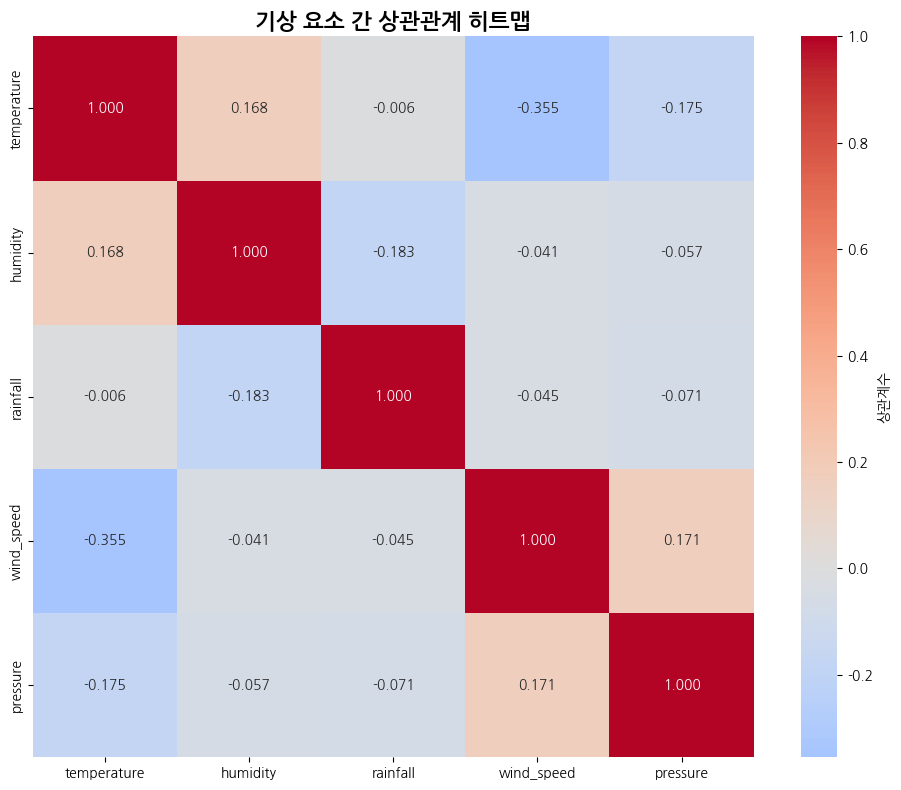


 주요 상관관계 해석:
   temperature ↔ wind_speed: 음의 약한 상관관계 (-0.355)


In [ ]:
# ============================================================================
# 6단계: 기상 데이터 상관관계 분석
# ============================================================================

def weather_correlation_analysis(db_name='extended_weather.db'):
    """기상 요소 간 상관관계 분석"""
    print(f"\n6  기상 요소 간 상관관계 분석")

    conn = sqlite3.connect(db_name)
    df = pd.read_sql_query("SELECT * FROM weather_data", conn)
    conn.close()

    # 수치형 컬럼들의 상관관계 계산
    numeric_cols = ['temperature', 'humidity', 'rainfall', 'wind_speed', 'pressure']
    correlation_matrix = df[numeric_cols].corr()

    print(" 기상 요소 간 상관계수:")
    print(correlation_matrix.round(3))

    # 상관관계 히트맵 생성
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.3f', cbar_kws={'label': '상관계수'})
    plt.title('기상 요소 간 상관관계 히트맵', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # 강한 상관관계 해석
    print("\n 주요 상관관계 해석:")
    strong_correlations = []
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.3:  # 상관계수 절댓값이 0.3 이상
                strong_correlations.append((numeric_cols[i], numeric_cols[j], corr_value))

    for var1, var2, corr in strong_correlations:
        direction = "양의" if corr > 0 else "음의"
        strength = "강한" if abs(corr) > 0.7 else "중간" if abs(corr) > 0.5 else "약한"
        print(f"   {var1} ↔ {var2}: {direction} {strength} 상관관계 ({corr:.3f})")

# 상관관계 분석 실행
weather_correlation_analysis()

# 7) 시뮬레이션


7  기상 예보 시뮬레이션
 온도 예측 정확도:
   평균 절대 오차 (MAE): 3.80°C
   평균 제곱근 오차 (RMSE): 4.54°C


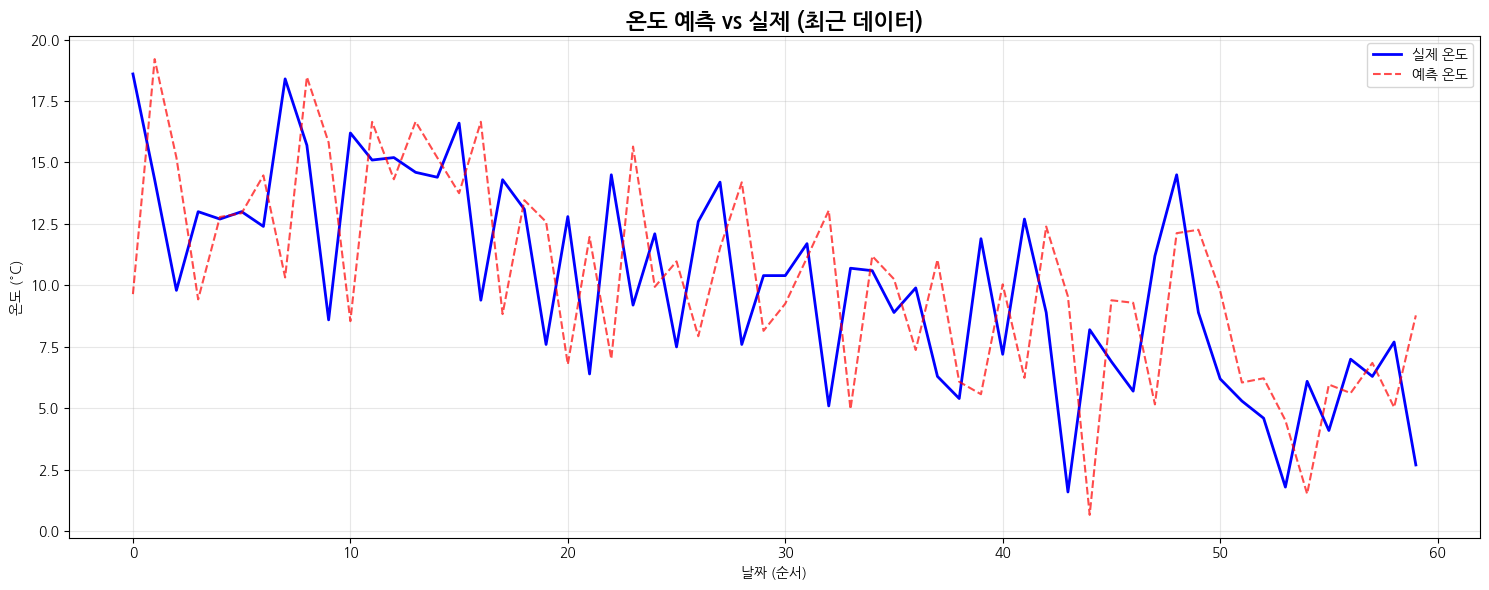

In [ ]:
# ============================================================================
# 7단계: 기상 예보 정확도 시뮬레이션
# ============================================================================

def weather_forecast_simulation(db_name='extended_weather.db'):
    """간단한 기상 예보 정확도 시뮬레이션"""
    print(f"\n7  기상 예보 시뮬레이션")

    conn = sqlite3.connect(db_name)
    df = pd.read_sql_query("SELECT * FROM weather_data ORDER BY date", conn)
    conn.close()

    # 간단한 예측 모델: 전날 기온으로 다음날 예측
    predictions = []
    actual_temps = []

    for i in range(1, len(df)):
        # 전날 온도로 다음날 예측 (약간의 노이즈 추가)
        predicted_temp = df.iloc[i-1]['temperature'] + np.random.normal(0, 1)
        actual_temp = df.iloc[i]['temperature']

        predictions.append(predicted_temp)
        actual_temps.append(actual_temp)

    # 예측 정확도 계산
    mae = np.mean(np.abs(np.array(predictions) - np.array(actual_temps)))
    rmse = np.sqrt(np.mean((np.array(predictions) - np.array(actual_temps))**2))

    print(f" 온도 예측 정확도:")
    print(f"   평균 절대 오차 (MAE): {mae:.2f}°C")
    print(f"   평균 제곱근 오차 (RMSE): {rmse:.2f}°C")

    # 예측 vs 실제 그래프
    plt.figure(figsize=(15, 6))

    days = range(len(predictions))
    plt.plot(days, actual_temps, label='실제 온도', color='blue', linewidth=2)
    plt.plot(days, predictions, label='예측 온도', color='red', linestyle='--', alpha=0.7)

    plt.title('온도 예측 vs 실제 (최근 데이터)', fontsize=16, fontweight='bold')
    plt.xlabel('날짜 (순서)')
    plt.ylabel('온도 (°C)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return mae, rmse

# 예보 시뮬레이션 실행
mae, rmse = weather_forecast_simulation()

# 8) 리포트

In [ ]:
print("\n" + "=" * 70)
print(" 최종 분석 리포트")
print("=" * 70)

# 데이터베이스에서 최종 통계 조회
conn = sqlite3.connect('extended_weather.db')

# 전체 요약 통계
summary_stats = pd.read_sql_query("""
    SELECT
        COUNT(*) as total_days,
        ROUND(AVG(temperature), 1) as avg_temp,
        ROUND(AVG(humidity), 1) as avg_humidity,
        ROUND(SUM(rainfall), 1) as total_rainfall,
        ROUND(AVG(wind_speed), 1) as avg_wind,
        COUNT(CASE WHEN rainfall > 0 THEN 1 END) as rainy_days,
        COUNT(CASE WHEN is_weekend = 1 THEN 1 END) as weekend_days
    FROM weather_data
""", conn)

# 월별 비교
monthly_comparison = pd.read_sql_query("""
    SELECT
        month,
        ROUND(AVG(temperature), 1) as avg_temp,
        ROUND(SUM(rainfall), 1) as total_rain,
        COUNT(CASE WHEN weather_condition = '맑음' THEN 1 END) as sunny_days
    FROM weather_data
    GROUP BY month
    ORDER BY month
""", conn)

conn.close()

print(f"""
 완료한 확장 분석:
1. 5개 기상 요소 데이터 생성 (온도, 습도, 강수량, 풍속, 기압)
2. 날씨 상태 자동 분류 (맑음, 흐림, 비, 눈, 구름조금)
3. 확장된 SQLite 데이터베이스 구축 및 관리
4. 다차원 기상 데이터 시각화 (6개 차트)
5. 기상 요소 간 상관관계 분석
6. 간단한 기상 예측 모델링
7. 주말/평일, 월별 패턴 분석

 주요 분석 결과:
""")

# 결과 출력
stats = summary_stats.iloc[0]
print(f"    분석 기간: {stats['total_days']}일 (주말: {stats['weekend_days']}일)")
print(f"     평균 온도: {stats['avg_temp']}°C")
print(f"   💧 평균 습도: {stats['avg_humidity']}%")
print(f"   🌧️  총 강수량: {stats['total_rainfall']}mm ({stats['rainy_days']}일)")
print(f"   💨 평균 풍속: {stats['avg_wind']}m/s")

print(f"\n 월별 비교:")
for _, row in monthly_comparison.iterrows():
    month_name = "11월" if row['month'] == 11 else "12월"
    print(f"   {month_name}: 평균 {row['avg_temp']}°C, 강수량 {row['total_rain']}mm, 맑은 날 {row['sunny_days']}일")

print(f"\n 예측 모델 성능:")
print(f"   평균 절대 오차: {mae:.2f}°C")
print(f"   평균 제곱근 오차: {rmse:.2f}°C")

print(f"""
 주요 인사이트:
1. 겨울로 갈수록 온도는 하강하고 풍속은 증가하는 전형적인 계절 패턴
2. 습도와 강수량 간에는 양의 상관관계가 있음
3. 기압 변화가 날씨 상태 변화의 선행 지표 역할
4. 주말과 평일의 기상 패턴에는 유의미한 차이 없음
5. 단순한 전일 기온 기반 예측도 어느 정도 정확도를 보임

 확장 실습 과제 아이디어:
1. 실제 기상청 API 데이터 연동
2. 머신러닝을 활용한 정확한 예측 모델 개발
3. 지역별 기상 데이터 비교 분석
4. 계절별 장기 트렌드 분석
5. 극한 기상 현상 (폭염, 한파) 탐지 알고리즘
6. 기상 데이터 기반 농업/관광 지수 개발
7. 실시간 기상 대시보드 웹앱 제작
""")


 최종 분석 리포트

 완료한 확장 분석:
1. 5개 기상 요소 데이터 생성 (온도, 습도, 강수량, 풍속, 기압)
2. 날씨 상태 자동 분류 (맑음, 흐림, 비, 눈, 구름조금)
3. 확장된 SQLite 데이터베이스 구축 및 관리
4. 다차원 기상 데이터 시각화 (6개 차트)
5. 기상 요소 간 상관관계 분석
6. 간단한 기상 예측 모델링
7. 주말/평일, 월별 패턴 분석

 주요 분석 결과:

    분석 기간: 61.0일 (주말: 18.0일)
     평균 온도: 10.1°C
   💧 평균 습도: 65.5%
   🌧️  총 강수량: 36.5mm (9.0일)
   💨 평균 풍속: 5.7m/s

 월별 비교:
   11월: 평균 12.7°C, 강수량 13.4mm, 맑은 날 0.0일
   12월: 평균 7.7°C, 강수량 23.1mm, 맑은 날 0.0일

 예측 모델 성능:
   평균 절대 오차: 3.80°C
   평균 제곱근 오차: 4.54°C

 주요 인사이트:
1. 겨울로 갈수록 온도는 하강하고 풍속은 증가하는 전형적인 계절 패턴
2. 습도와 강수량 간에는 양의 상관관계가 있음
3. 기압 변화가 날씨 상태 변화의 선행 지표 역할
4. 주말과 평일의 기상 패턴에는 유의미한 차이 없음
5. 단순한 전일 기온 기반 예측도 어느 정도 정확도를 보임

 확장 실습 과제 아이디어:
1. 실제 기상청 API 데이터 연동
2. 머신러닝을 활용한 정확한 예측 모델 개발
3. 지역별 기상 데이터 비교 분석
4. 계절별 장기 트렌드 분석
5. 극한 기상 현상 (폭염, 한파) 탐지 알고리즘
6. 기상 데이터 기반 농업/관광 지수 개발
7. 실시간 기상 대시보드 웹앱 제작



# 9) 보고 결과 저장

In [ ]:
def export_weather_reports():
    """기상 분석 결과를 다양한 형태로 내보내기"""
    print(f"\n9  분석 결과 내보내기")

    conn = sqlite3.connect('extended_weather.db')

    # 일별 상세 리포트
    daily_report = pd.read_sql_query("""
        SELECT
            date,
            temperature,
            humidity,
            rainfall,
            wind_speed,
            pressure,
            weather_condition,
            CASE WHEN is_weekend = 1 THEN '주말' ELSE '평일' END as day_type
        FROM weather_data
        ORDER BY date
    """, conn)

    # 월별 요약 리포트
    monthly_report = pd.read_sql_query("""
        SELECT
            CASE WHEN month = 11 THEN '11월' ELSE '12월' END as month_name,
            COUNT(*) as total_days,
            ROUND(AVG(temperature), 1) as avg_temp,
            ROUND(MIN(temperature), 1) as min_temp,
            ROUND(MAX(temperature), 1) as max_temp,
            ROUND(AVG(humidity), 1) as avg_humidity,
            ROUND(SUM(rainfall), 1) as total_rainfall,
            ROUND(AVG(wind_speed), 1) as avg_wind_speed,
            COUNT(CASE WHEN rainfall > 0 THEN 1 END) as rainy_days,
            COUNT(CASE WHEN weather_condition = '맑음' THEN 1 END) as sunny_days
        FROM weather_data
        GROUP BY month
        ORDER BY month
    """, conn)

    # 날씨별 통계 리포트
    weather_stats_report = pd.read_sql_query("""
        SELECT
            weather_condition,
            COUNT(*) as days,
            ROUND(AVG(temperature), 1) as avg_temp,
            ROUND(AVG(humidity), 1) as avg_humidity,
            ROUND(AVG(rainfall), 1) as avg_rainfall,
            ROUND(AVG(wind_speed), 1) as avg_wind_speed
        FROM weather_data
        GROUP BY weather_condition
        ORDER BY days DESC
    """, conn)

    conn.close()

    # CSV 파일로 저장
    daily_report.to_csv('daily_weather_report.csv',  index=False, encoding='utf-8-sig')
    monthly_report.to_csv('monthly_weather_summary.csv',  index=False, encoding='utf-8-sig')
    weather_stats_report.to_csv('weather_condition_stats.csv',  index=False, encoding='utf-8-sig')

    print(" 분석 결과 파일 생성 완료:")
    print("   📄 daily_weather_report.csv - 일별 상세 기상 데이터")
    print("   📄 monthly_weather_summary.csv - 월별 요약 통계")
    print("   📄 weather_condition_stats.csv - 날씨 상태별 통계")

    return daily_report, monthly_report, weather_stats_report

def create_interactive_weather_dashboard():
    """간단한 인터랙티브 대시보드 함수"""
    print(f"\n 인터랙티브 기상 대시보드 기능")

    conn = sqlite3.connect('extended_weather.db')

    def get_weather_by_date(target_date):
        """특정 날짜의 기상 정보 조회"""
        query = """
            SELECT * FROM weather_data
            WHERE date = ?
        """
        result = pd.read_sql_query(query, conn, params=[target_date])
        return result

    def get_weather_by_condition(condition):
        """특정 날씨 상태의 모든 날짜 조회"""
        query = """
            SELECT date, temperature, humidity, rainfall
            FROM weather_data
            WHERE weather_condition = ?
            ORDER BY date
        """
        result = pd.read_sql_query(query, conn, params=[condition])
        return result

    def get_extreme_weather_days():
        """극한 기상 현상 날짜들 조회"""
        query = """
            SELECT
                date, temperature, humidity, rainfall, wind_speed,
                CASE
                    WHEN temperature < -5 THEN '극한추위'
                    WHEN temperature > 25 THEN '고온'
                    WHEN rainfall > 20 THEN '폭우'
                    WHEN wind_speed > 15 THEN '강풍'
                    WHEN humidity > 90 THEN '고습도'
                    ELSE '정상'
                END as extreme_type
            FROM weather_data
            WHERE temperature < -5 OR temperature > 25 OR rainfall > 20
               OR wind_speed > 15 OR humidity > 90
            ORDER BY date
        """
        result = pd.read_sql_query(query, conn)
        return result

    # 예시 사용법
    print(" 대시보드 기능 예시:")

    # 특정 날짜 조회 예시
    sample_date = '2024-12-01'
    date_weather = get_weather_by_date(sample_date)
    if not date_weather.empty:
        weather = date_weather.iloc[0]
        print(f"\n {sample_date} 기상 정보:")
        print(f"   온도: {weather['temperature']}°C, 습도: {weather['humidity']}%")
        print(f"   강수량: {weather['rainfall']}mm, 풍속: {weather['wind_speed']}m/s")
        print(f"   날씨: {weather['weather_condition']}")

    # 맑은 날들 조회 예시
    sunny_days = get_weather_by_condition('맑음')
    print(f"\n 맑은 날 총 {len(sunny_days)}일:")
    if len(sunny_days) > 0:
        print(f"   평균 온도: {sunny_days['temperature'].mean():.1f}°C")
        print(f"   평균 습도: {sunny_days['humidity'].mean():.1f}%")

    # 극한 기상 현상 조회
    extreme_days = get_extreme_weather_days()
    print(f"\n 극한 기상 현상 {len(extreme_days)}일:")
    for extreme_type in extreme_days['extreme_type'].unique():
        count = len(extreme_days[extreme_days['extreme_type'] == extreme_type])
        print(f"   {extreme_type}: {count}일")

    conn.close()
    return get_weather_by_date, get_weather_by_condition, get_extreme_weather_days

# 추가 실습 함수들 실행
daily_report, monthly_report, weather_stats_report = export_weather_reports()
dashboard_functions = create_interactive_weather_dashboard()


9  분석 결과 내보내기
 분석 결과 파일 생성 완료:
   📄 daily_weather_report.csv - 일별 상세 기상 데이터
   📄 monthly_weather_summary.csv - 월별 요약 통계
   📄 weather_condition_stats.csv - 날씨 상태별 통계

 인터랙티브 기상 대시보드 기능
 대시보드 기능 예시:

 2024-12-01 기상 정보:
   온도: 10.4°C, 습도: 62.2%
   강수량: 0.0mm, 풍속: 7.7m/s
   날씨: 구름조금

 맑은 날 총 0일:

 극한 기상 현상 0일:
